In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
import cv2
from PIL import Image

## Load data

In [2]:
network_dim = int(256/2)  # ensure that this is always greater than max node number that occurs in your data
                      # in addition it needs to fit to the unet layer for concatenation

In [3]:
#graphs
# #masks = glob.glob("../input/graph_images/train/label/*.png")
# masks = np.load('../input/graph_images/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()
# orgs = glob.glob("../input/graph_images/train/image/*.png")

#training images
#masks = np.load('S:/06_Studienarbeit/03_CNN/generate_data/data/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()
masks = glob.glob('S:/06_Studienarbeit/03_CNN/generate_data/data/train_less128_2000imgs/label/*')
masks = masks[0:500]
orgs = glob.glob("S:/06_Studienarbeit/03_CNN/generate_data/data/train_less128_2000imgs/image/*.png")
orgs = orgs[0:500]
#every training image has less than 128 nodes

In [4]:
# graph images
# imgs_list = []
# masks_list = []
# for image, mask in zip(orgs, masks):
#     imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))
#     #print(image)
#     key = image
#     #print(key[-14:-9])
#     graph_label = masks[key[-14:-9]]
#     masks_list.append(np.array(graph_label))
#
# imgs_np = np.asarray(imgs_list)
# masks_np = np.asarray(masks_list)
# y_positions_label = masks_np[:,:,0:2]
# y_adjacency_label = masks_np[:,:,2:37]


In [5]:
#training images
imgs_list = []
masks_list = []
#masks_list_position = []
#masks_list_adjacency = []
for image, mask in zip(orgs, masks):
    I = cv2.imread(image)
    key = image
    print(key[-14:-9])
    #graph_label = masks[key[-14:-9]]
    graph_label = np.load(masks[int(key[-14:-9])], allow_pickle=True)
    graph_label_norm = graph_label.copy()
    positions = graph_label[:, :2, 0]
    #normalize positions
    pos_norm = np.zeros(positions.shape)
    for i in range(len(positions)):
        pos_norm[i][0] = np.round((positions[i][0]/I.shape[1])*512, 0)
        pos_norm[i][1] = np.round((positions[i][1] /I.shape[0])*512, 0)
    graph_label_norm[:, :2, 0] = pos_norm
    #pad the label to obtain uniform array sizes
    graph_label_padded = np.pad(graph_label_norm, ((0, 128-graph_label.shape[0]), (0, 130-graph_label.shape[1]), (0, 0)))
    imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))
    #masks_list_position.append(np.array(graph_label_norm[:, 0:2, 0]))
    #masks_list_adjacency.append(np.array(graph_label_norm[:, 2:, 0]))
    masks_list.append(graph_label_padded)

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)
#masks_position_np = np.asarray(masks_list_position)
#masks_adjacency_np = np.asarray(masks_list_adjacency)

#uniform array sizes are necessary
y_positions_label = masks_np[:, :, 0:2, 0]
y_adjacency_label = masks_np[:,:,2:130, 0]

#y_positions_label = masks_position_np.copy()
#y_adjacency_label = masks_adjacency_np.copy()

00000
00001
00002
00003
00004
00005
00006
00007
00008
00009
00010
00011
00012
00013
00014
00015
00016
00017
00018
00019
00020
00021
00022
00023
00024
00025
00026
00027
00028
00029
00030
00031
00032
00033
00034
00035
00036
00037
00038
00039
00040
00041
00042
00043
00044
00045
00046
00047
00048
00049
00050
00051
00052
00053
00054
00055
00056
00057
00058
00059
00060
00061
00062
00063
00064
00065
00066
00067
00068
00069
00070
00071
00072
00073
00074
00075
00076
00077
00078
00079
00080
00081
00082
00083
00084
00085
00086
00087
00088
00089
00090
00091
00092
00093
00094
00095
00096
00097
00098
00099
00100
00101
00102
00103
00104
00105
00106
00107
00108
00109
00110
00111
00112
00113
00114
00115
00116
00117
00118
00119
00120
00121
00122
00123
00124
00125
00126
00127
00128
00129
00130
00131
00132
00133
00134
00135
00136
00137
00138
00139
00140
00141
00142
00143
00144
00145
00146
00147
00148
00149
00150
00151
00152
00153
00154
00155
00156
00157
00158
00159
00160
00161
00162
00163
00164
00165
0016

## Plot images + masks + overlay (mask over original)

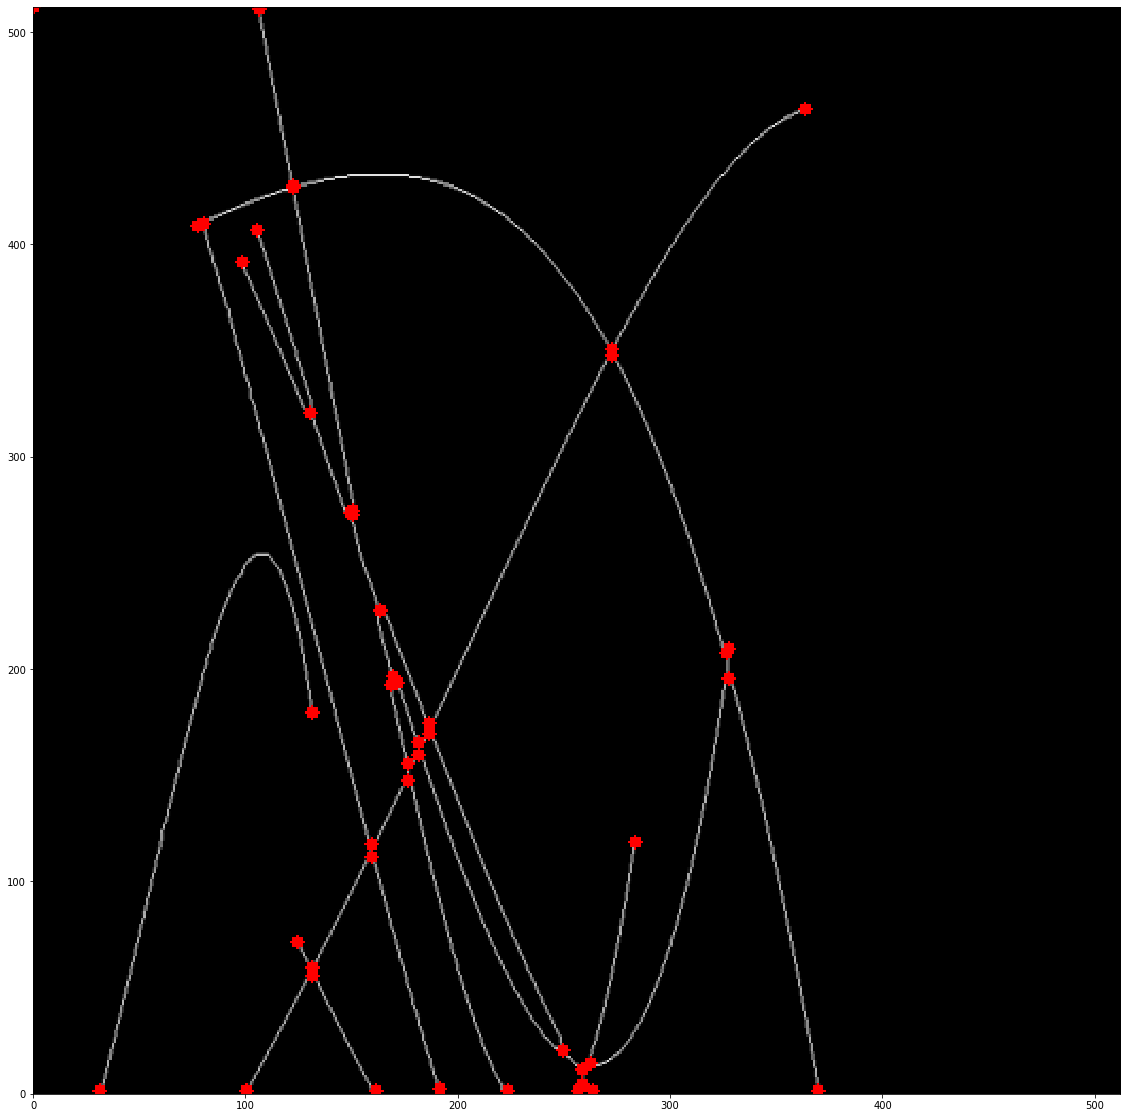

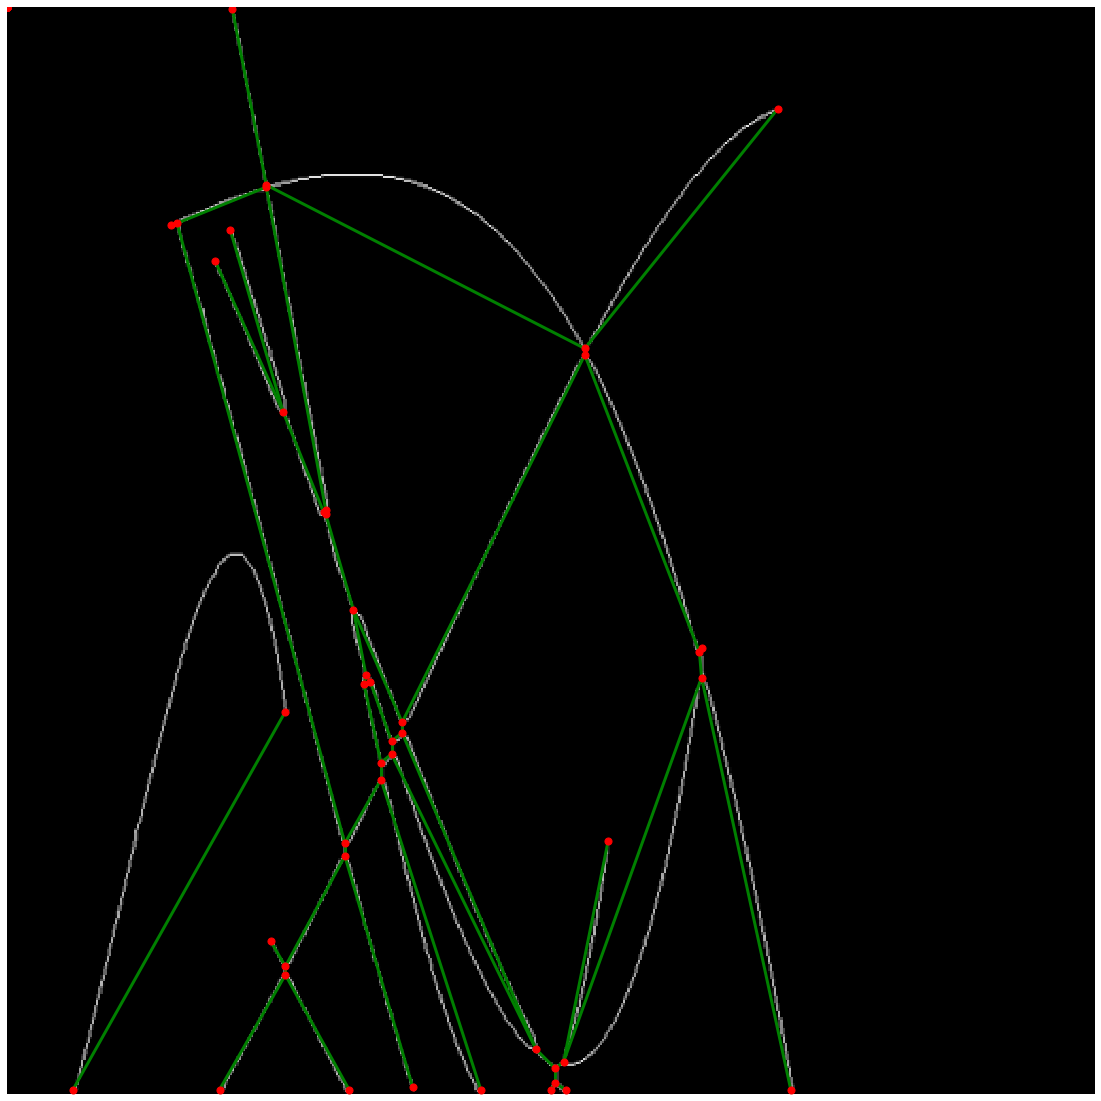

In [73]:
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img

node_thick = 6
index = 3
save = True
node_img = plot_nodes_on_img(imgs_np[index], y_positions_label[index], node_thick)

index = 3
fig = plot_graph_on_img(imgs_np[index], y_positions_label[index], y_adjacency_label[index])

In [48]:
# form position matrix and adjacency in a one dimensional vector information
y_positions_label = y_positions_label.reshape((y_positions_label.shape[0],y_positions_label.shape[1]*2))

adjacency_label_indices = np.triu_indices(y_adjacency_label.shape[1], k = 1)
y_adjacency_label =y_adjacency_label[:,adjacency_label_indices[0],adjacency_label_indices[1]]
y_label = [y_positions_label,y_adjacency_label]
print('total number of positions: ', y_positions_label.shape)
print('total number of relevant adjacency etries: ', y_adjacency_label.shape)

total number of positions:  (500, 256)
total number of relevant adjacency etries:  (500, 8128)


In [7]:
print(imgs_np.shape, y_label[0].shape, y_label[1].shape )


(500, 512, 512) (500, 256) (500, 8128)


## Get data into correct shape, dtype and range (0.0-1.0)

In [9]:
print(imgs_np.max(), masks_np.max())

255 1463.3382462220002


In [10]:
x = np.asarray(imgs_np, dtype=np.float32)/255
#y = np.asarray(masks_np, dtype=np.float32)/255

In [11]:
# tailor the data to the specific pre defined network dimension
y_label_positions = y_label[0]
y_label_adjacency = y_label[1]

a = np.full((y_label_positions.shape[0],network_dim *2), -9.9)
adj_flatten_dim = int((network_dim*network_dim-network_dim)/2)
b = np.zeros((y_label[1].shape[0],adj_flatten_dim))

a[:,0:y_label_positions.shape[1]] = y_label_positions
b[:,0:y_label_adjacency.shape[1]]= y_label_adjacency

y_label = [a, b]

In [12]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

##  Train/val split

In [13]:
from sklearn.model_selection import train_test_split
# split data
x_train, x_val, y_train_positions,y_val_positions, y_train_adjacency, y_val_adjacency = train_test_split(x, y_label[0], y_label[1], test_size=0.1, random_state=0)
print("x_train: ", x_train.shape)
print("y_train_positions: ", y_train_positions.shape)
print(" y_train_adjacency: ", y_train_adjacency.shape)
print("x_val: ", x_val.shape)
print("y_val_positions: ", y_val_positions.shape)
print("y_val_adjacency: ", y_val_adjacency.shape)

from models_graph.prepare_functions import convert_to_tensor

# convert from numpy to tensorflow object
x_train = convert_to_tensor(x_train)
x_val = convert_to_tensor(x_val)
y_train_positions = convert_to_tensor(y_train_positions)
y_train_adjacency = convert_to_tensor(y_train_adjacency)
y_val_positions = convert_to_tensor(y_val_positions)
y_val_adjacency = convert_to_tensor(y_val_adjacency)

x_train:  (450, 512, 512, 1)
y_train_positions:  (450, 256)
 y_train_adjacency:  (450, 8128)
x_val:  (50, 512, 512, 1)
y_val_positions:  (50, 256)
y_val_adjacency:  (50, 8128)


## Initialize network

In [14]:
from models_graph.custom_graph_head import custom_graph_head, custom_adj_unet
print(x_train.shape)
input_shape = (512, 512, 1)
model = custom_adj_unet(input_size = input_shape, pretrained_weights =None, network_dim = network_dim)

(450, 512, 512, 1)


## Network shape

In [15]:
print('Input Shape: ',model.input_shape)
print('Output Shape: ',model.output_shape)
print('with position vector: ',model.output_shape[0], ' and adjacency vector: ', model.output_shape[1])

model.summary()

Input Shape:  (None, 512, 512, 1)
Output Shape:  [(None, 256), (None, 8128)]
with position vector:  (None, 256)  and adjacency vector:  (None, 8128)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 

In [16]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin\\"
import sys
print(sys.path)
sys.path.append("C:\\Program Files\\Graphviz\\bin\\")

['D:\\Documents\\Studium\\Studienarbeit\\keras-unet\\notebooks', 'D:\\Documents\\Studium\\Studienarbeit\\keras-unet', 'C:\\Users\\Regine\\AppData\\Local\\Programs\\Python\\Python39', 'C:\\Users\\Regine\\AppData\\Local\\Programs\\Python\\Python36', 'C:\\Users\\Regine\\AppData\\Local\\Programs\\Python\\Python39\\python39.zip', 'C:\\Users\\Regine\\AppData\\Local\\Programs\\Python\\Python39\\DLLs', 'C:\\Users\\Regine\\AppData\\Local\\Programs\\Python\\Python39\\lib', '', 'C:\\Users\\Regine\\AppData\\Roaming\\Python\\Python39\\site-packages', '\\\\isys-cifs.tik.uni-stuttgart.de\\isys_shared\\studenten\\rausch\\06_studienarbeit\\02_buildgraph\\retipy-python\\retipy', 'C:\\Users\\Regine\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32', 'C:\\Users\\Regine\\AppData\\Roaming\\Python\\Python39\\site-packages\\win32\\lib', 'C:\\Users\\Regine\\AppData\\Roaming\\Python\\Python39\\site-packages\\Pythonwin', 'C:\\Users\\Regine\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages',

In [17]:
import tensorflow.python.keras as keras
# from keras.utils import plot_model
# plot_model(model, to_file='model.png')

from tensorflow.keras.callbacks import ModelCheckpoint
model_filename = 'graph_extract_model_v0.h5'
callback_checkpoint = ModelCheckpoint(model_filename)

## Compile + train

In [18]:
#import keras as keras
import tensorflow as tf
import tensorflow.python.keras as keras
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD
#from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency
# model.compile(
#      optimizer=keras.optimizers.RMSprop(1e-3),
#      loss={
#          "pixel_position_of_nodes": loss_node_positions,
#          "adjacency_matrix":  loss_adjacency,
#      },
#      loss_weights=[1.0, 1.0],
#  )

In [19]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime

model.compile(
   optimizer=tf.keras.optimizers.RMSprop(1e-3),
   loss={
       "pixel_position_of_nodes": keras.losses.MeanSquaredError(),
       "adjacency_matrix":   keras.losses.BinaryCrossentropy(),
   },
   loss_weights=[0.8, 1.0],
)
#print('done')
model.output

[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'pixel_position_of_nodes')>,
 <KerasTensor: shape=(None, 8128) dtype=float32 (created by layer 'adjacency_matrix')>]

In [20]:
from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency

print(y_train_adjacency.shape)
print(y_train_positions.shape)
print(y_val_positions.shape)
print(y_val_adjacency.shape)
# model.fit({'input_image': x_train},{'pixel_position_of_nodes': y_train_positions, 'adjacency_matrix': y_train_adjacency},
#           epochs = 1, batch_size=2 ,
#           validation_data=({'input_image': x_val},{'pixel_position_of_nodes': y_val_positions, 'adjacency_matrix': y_val_adjacency}),
#         )
#

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x_train, [y_train_positions, y_train_adjacency],
          epochs = 10, batch_size=1 ,
          validation_data=(x_val,{'pixel_position_of_nodes': y_val_positions, 'adjacency_matrix': y_val_adjacency}),
          callbacks=[tensorboard_callback],)
#model.fit(x= x_train,y=[y_train_positions, y_train_adjacency] , epochs=10)

(450, 8128)
(450, 256)
(50, 256)
(50, 8128)
Epoch 1/10
  6/450 [..............................] - ETA: 50:55 - loss: 4855949.5000 - pixel_position_of_nodes_loss: 6069929.5000 - adjacency_matrix_loss: 5.7907  

KeyboardInterrupt: 

In [75]:
# Save the entire model to a HDF5 file
model.save(model_filename)

## Plot training history

In [21]:
#import numpy as np
#save history
#np.save('D:\Documents\Studium\Studienarbeit\keras-unet/my_history.npy',history.history)

#load history
# history = np.load('D:\Documents\Studium\Studienarbeit\keras-unet/my_history.npy',allow_pickle='TRUE').item()
#
# model.history = history

In [ ]:
from keras_unet.utils import plot_segm_history
plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [32]:
#compute prediction
#model.load_weights(model_filename)
#first three elements in validation set
print(x_val.shape)
x_val012 = x_val[:3, :, :, :]
y_pred = model.predict(x_val012)
predicted_adjacency_matrices = y_pred[1]
predicted_positions = y_pred[0]

predicted_adjacency0 = predicted_adjacency_matrices[0, :]
predicted_adjacency1 = predicted_adjacency_matrices[1, :]
predicted_adjacency2 = predicted_adjacency_matrices[2, :]

predicted_positions0 = predicted_positions[0, :]
predicted_positions1 = predicted_positions[1, :]
predicted_positions2 = predicted_positions[2, :]

(50, 512, 512, 1)


In [43]:
#reshape
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img
from models_graph.prepare_functions import create_adj_matrix, create_position_matrix

test_postion = masks_np[2,:,0:2, 0]
test_adj     = masks_np[2,:,2:130, 0]
adj_vector =  y_adjacency_label[2,:]
size = 35 # we need to check how many nodes were detected, however, for now just a fixed limit

# Test
test_adj_matrix = create_adj_matrix(y_val_adjacency.numpy()[2,:],35)
test_position_matrix = create_position_matrix(y_val_positions.numpy()[2,:],35)

adj_matrix0 = create_adj_matrix(predicted_adjacency0,17)
position_matrix0 = create_position_matrix(predicted_positions0,17)

if test_postion.all() == test_position_matrix.all():
    print(True)
if test_adj.all() == test_adj_matrix.all() :
    print(True)

True
True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


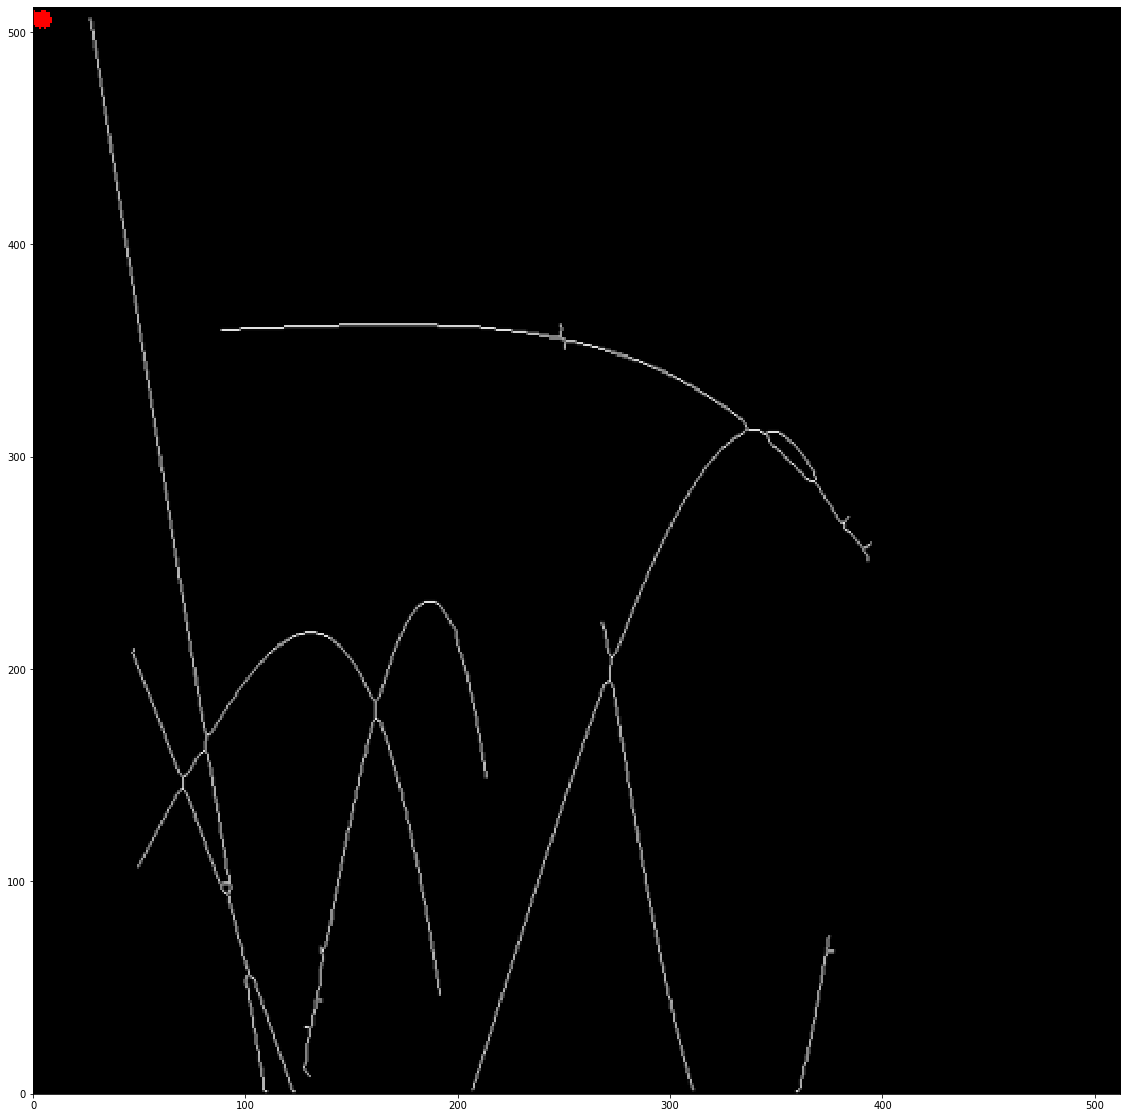

In [72]:
from keras_unet.utils_regine import plot_graph_on_img, plot_nodes_on_img

#plot nodes on img
node_thick = 6
index = 0
node_img = plot_nodes_on_img(x_val.numpy()[index, :, :, 0], position_matrix0, node_thick)

#plot graph on img
# index = 0
# fig = plot_graph_on_img(x_val.numpy[index, :, :, 0], position_matrix0, adj_matrix0)

In [ ]:
from keras_unet.utils import plot_imgs
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)
